In [7]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from scipy.stats import kendalltau

PROJECT_ROOT = os.path.abspath(os.path.join(sys.path[0], os.pardir))
sys.path.append(PROJECT_ROOT)

In [13]:
results_root = '../results/tmp_during_refactor/ranking_no_winter_no_nighttime/'
results_f = dict()
for pair_sampling in ['random_pair_sampling', 'disch_dist_pair_sampling']:
    results_f[pair_sampling] = dict()
    for annotator_type in ['simulated_annotator', 'oracle_annotator_margin_0.25']:
        results_f[pair_sampling][annotator_type] = dict()
        for n_pairs in [1000, 3000, 5000]:
            n_pairs_str = f"{n_pairs}_pairs"
            results_dir = os.path.join(
                results_root, pair_sampling, annotator_type, n_pairs_str,
                'train_ranking_model_AVERYBB_1', 'epoch*_inference', 'inference_ranking_model_1', 'inference_results_flow-images.csv'
            )
            results_files = glob(results_dir)
            assert len(results_files) == 1
            results_f[pair_sampling][annotator_type][n_pairs] = results_files[0]


In [23]:
test_ktau = dict()
for pair_sampling in ['random_pair_sampling', 'disch_dist_pair_sampling']:
    test_ktau[pair_sampling] = dict()
    for annotator_type in ['simulated_annotator', 'oracle_annotator_margin_0.25']:
        test_ktau[pair_sampling][annotator_type] = dict()
        for n_pairs in [1000, 3000, 5000]:
            inf_results = pd.read_csv(results_f[pair_sampling][annotator_type][n_pairs])
            test_data_f = os.path.abspath(os.path.join(results_f[pair_sampling][annotator_type][n_pairs], '../../../', 'test_data.csv'))
            test_data = pd.read_csv(test_data_f)
            test_inf_results = inf_results[inf_results['url'].isin(test_data['url'])]
            test_ktau[pair_sampling][annotator_type][n_pairs] = kendalltau(test_inf_results['flow_cfs'], test_inf_results['scores'])
            # assert False, 'break'

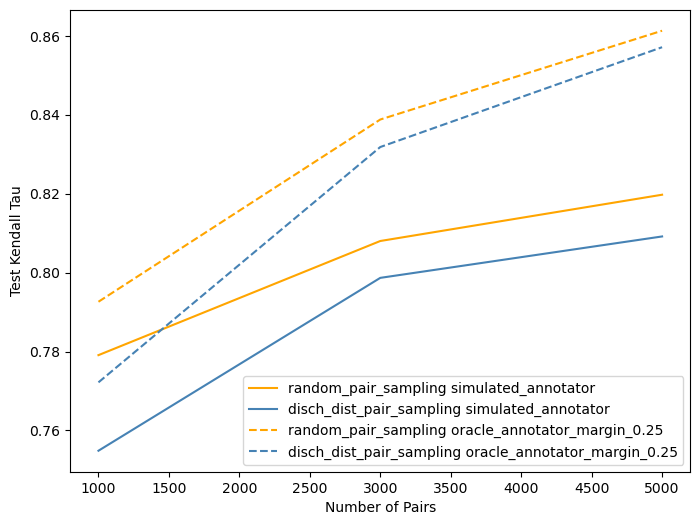

In [29]:
# plot
colors = {'random_pair_sampling': 'orange', 'disch_dist_pair_sampling': 'steelblue'}
line_styles = {'simulated_annotator': '-', 'oracle_annotator_margin_0.25': '--'}
fig, ax = plt.subplots(figsize=(8, 6))
for annotator_type in ['simulated_annotator', 'oracle_annotator_margin_0.25']:
    for pair_sampling in ['random_pair_sampling', 'disch_dist_pair_sampling']:
        color = colors[pair_sampling]
        line_style = line_styles[annotator_type]
        x = [1000, 3000, 5000]
        y = [test_ktau[pair_sampling][annotator_type][n_pairs][0] for n_pairs in x]
        ax.plot(x, y, line_style, c=color, label=f'{pair_sampling} {annotator_type}')
ax.legend()
ax.set_xlabel('Number of Pairs')
ax.set_ylabel('Test Kendall Tau')
plt.show()
